In [1]:
import cv2
import dlib
import os
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.7.0
19.24.1


# Step 1. 스티커 구하기
---
* 고양이 수염 이미지, 셀카 준비

# Step 2. 얼굴 검출 & 랜드마크 검출하기

### 이미지 rgb로 전환하여 불러오기

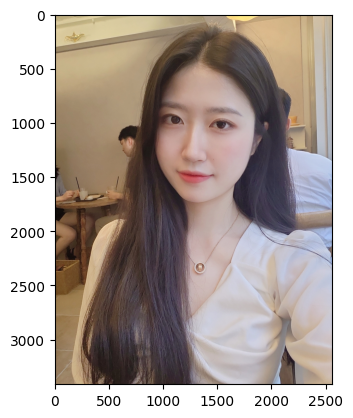

In [2]:
my_image_path='./data/selfie.png'
# OpenCV로 이미지 불러오기
img_bgr = cv2.imread(my_image_path)
#출력용 이미지 따로 보관
img_show = img_bgr.copy()
# bgr채널 rgb로 전환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#출력할 이미지 올리기 (출력x)
plt.imshow(img_rgb)
# 이미지 출력
plt.show()

### face detection (HOG & SVM 기반)
* HOG(Histogram of Oriented Gradients) : 색상 변화량
* SVM(Support Vector Machine) 

In [3]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog 시용해 얼굴의 bounding box 추출
# 두 번째 인자는 이미지 피라미드의 수 (이미지를 upsampling하여 크기 키운것)
dlib_rects = detector_hog(img_rgb, 1)

# 찾은 얼굴 영역의 좌표 출력
print(dlib_rects)

rectangles[[(741, 613) (1891, 1764)]]


741 613 1891 1764


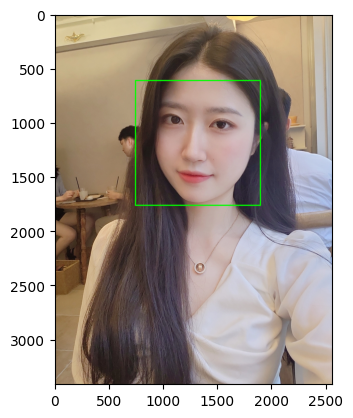

In [4]:
# detect한 얼굴 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top()  # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # 좌표 확인
    print(l, t, r, b)
    
    # bounding box 라인 그리기
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)
# 인자(detect시 사용한 이미지, (좌표), (좌표), (line색), line두께, line 종류)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# Step 3. 스티커 적용 위치 확인하기

### Face Landmark로 이목구비 위치 추론
---
landmark_predictor : RGB이미지와 dlib.rectangle (얼굴 예측한 bounding box)을 입력으로 받고 'dlib.full_detection (각 구성 요소와 이미지 상 객체의 위치)'을 반환

In [5]:
# landmark 모델 불러와서 사용
model_path = './model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [6]:
# 랜드마크 위치 저장할 list 생성
list_landmarks = []

for dlib_rect in dlib_rects:
    # 모든 랜드마크의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    # 각 랜드마크 위치정보를 (x,y) 형태로 변환하여 list_points에 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # list_landmakrs에 랜드마크 리스트 저장
    list_landmarks.append(list_points)

# 얼굴이 1개이므로 list_landmarks를 68개 랜드마크 위치가 list로 나열된 
# 1개의 원소를 가지므로 '[0]'으로 호출
print(len(list_landmarks[0]))

68


### 추출한 랜드마크 이미지에 출력

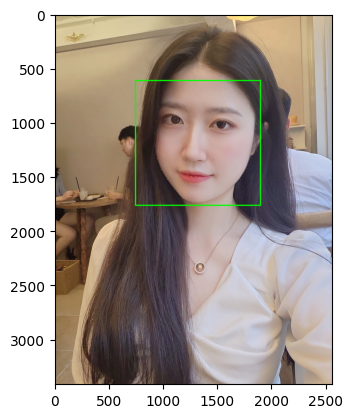

In [7]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

# Step 4. 스티커 적용하기

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # 코 index
    x = landmark[30][0] - dlib_rect.height()//2
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print (f'(x,y): ({x},{y})')
    print (f'(w,h): ({w},{h})')

(1259, 1299)
(x,y): (683,1299)
(w,h): (1151,1151)


(1151, 1151, 3)


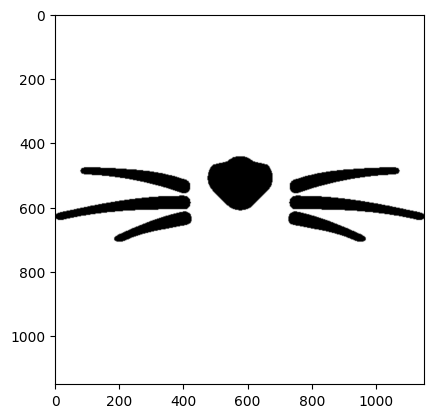

In [9]:
sticker_path = './data/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
print(img_sticker_rgb.shape)

plt.imshow(img_sticker_rgb)
plt.show()

In [10]:
refined_x = x
refined_y = y-h//2

print(f'(x,y) : ({refined_x}, {refined_y})')

(x,y) : (683, 724)


In [11]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

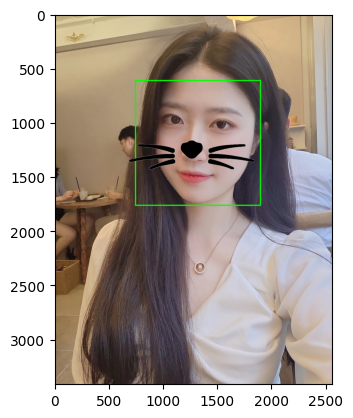

In [12]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

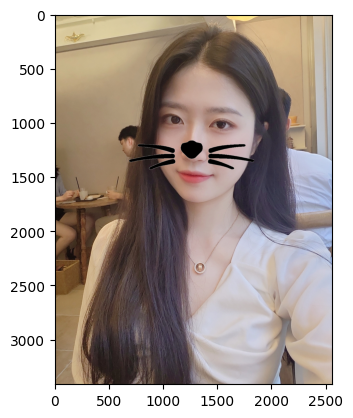

In [13]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

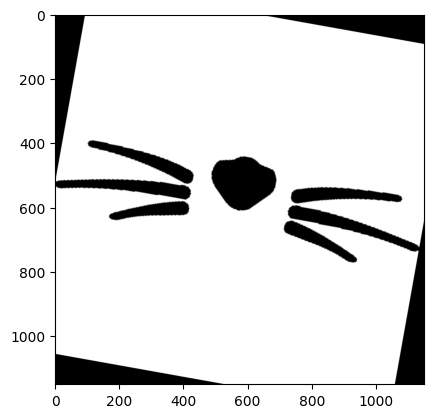

In [14]:
# 회전변환
import math
rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(270), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

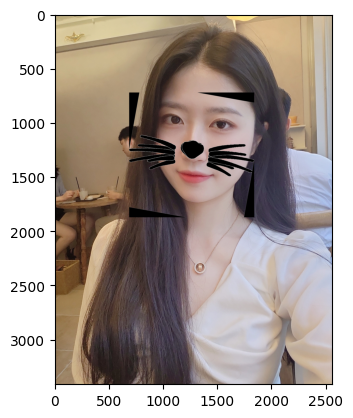

In [15]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# Step 5. 문제점 찾아보기

* 얼굴 각도에 맞추어 스티커를 회전시킨 후 적용시킴
    - cv2.getRotationMatrix2D를 이용해 고양이 수염 스티커를 얼굴 각도에 맞추어 회전시킴.
    - 회전행렬을 Affine변환하여 회전된 상태로 사진에 적용됨.
    - 회전 변환을 하고나면 빈공간이 생기고 default인 검은색으로 채워짐.
    - bpderValue 인자를 통해 빈공간의 색을 지정할 수 있지만 투명색으로 채우는 방법은 찾아봐야 함.
